<a href="https://colab.research.google.com/github/Enrico-Call/RL-AKI/blob/data-preparation/Data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#sets the project id
PROJECT_ID = "mlrh-330919" #@param {type:"string"}

In [2]:
import os
from google.colab import auth
from IPython.display import display
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MLRFH')
 
#sets dateset
PROJECT_ID = 'mlrh-330919'
DATASET_ID = 'version1_0_2'
LOCATION = 'eu'
 
#all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
 
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


In [3]:
#Some preprocessing functions 

def to_cols(data):

  grouped = data.pivot_table(index=['admissionid', 'time'], 
          columns=['item'], values='value')

  return grouped
  

def to_cols_action(data):

  grouped = data.pivot_table(index=['admissionid', 'time'], 
            columns=['item'], values='administered')

  return grouped

def remove_outliers(grouped):
  #delete outliers
  outliers = grouped.reset_index() #return to single index

  #select outlier cols
  all_cols = ['Kalium (bloed)', 'ABP gemiddeld', 'Kreatinine (bloed)', 'Natrium (bloed)', 'UrineCAD', 'UrineSupraPubis', 'UrineSpontaan', 'UrineUP', 'Kreatinine', 'Nefrodrain re Uit', 'Nefrodrain li Uit', 'UrineIncontinentie']
  
  grouped['Kalium (bloed)'][grouped['Kalium (bloed)'] > 8.] = np.nan
  grouped['ABP gemiddeld'][grouped['ABP gemiddeld'] > 200.] = np.nan
  grouped['Kreatinine (bloed)'][grouped['Kreatinine (bloed)'] > 220.] = np.nan
  grouped['Natrium (bloed)'][grouped['Natrium (bloed)'] > 180.] = np.nan
  grouped['UrineCAD'][grouped['UrineCAD'] > 750.] = np.nan


  #return grouped[grouped[all_cols] >= 0]
  grouped[all_cols] = grouped[all_cols].applymap(lambda x: np.nan if x < 0 else x)
  return grouped

def remove_outliers_action(grouped):
  #delete outliers
  outliers = grouped.reset_index() #return to single index

  cols = ['Noradrenaline (Norepinefrine)', 'NaCl 0,45%/Glucose 2,5%']

  #select outlier cols
  grouped['Noradrenaline (Norepinefrine)'][grouped['Noradrenaline (Norepinefrine)'] > 10.] = np.nan
  grouped['NaCl 0,45%/Glucose 2,5%'][grouped['NaCl 0,45%/Glucose 2,5%'] > 500.] = np.nan

  grouped[cols] = grouped[cols].applymap(lambda x: np.nan if x < 0 else x)

  return grouped

def aggregate(outliers_removed):
  #per patient, average the values in 4h timeslots
  outliers_removed = outliers_removed.sort_values('time')
  data_agg = outliers_removed.groupby([pd.Grouper(level='admissionid'), 
            pd.Grouper(level='time', freq='4H')]
          ).mean()

  return data_agg

def aggregate_fancy(data):

  #create new columns with cumulative count for consecutive nans
  data['nancount'] = np.zeros(len(data))
  data['nancount'] = data["Value"].groupby((data["Value"].notnull()).cumsum()).cumcount()

  #manually set first row to 1 if nan since this is excluded in cumsum/count from line before
  for i, v in enumerate(data["Value"]):
    if i == 0:
      if np.isnan(v):
        data["nancount"][0] = 1

  #if value is not nan, then use previous value + 1 to get total cumulative nan count including the non-nan value
  #this is the value we want to divide through to get the right value per hour
  for i, v in enumerate(data["nancount"]):
    if v == 0:
      data["Value"][i] = data["Value"][i] / (data["nancount"][i - 1] + 1)

  #and then fill backwards
  data["Value"] = data["Value"].bfill()
  
  #drop nancount col
  data = data.drop(columns="nancount")

  return data

def interpolate(data_agg):
  #interpolate null values
  return data_agg.interpolate(limit_direction='forward')


def process_statespace(data):
  data['time'] = pd.to_datetime(data['time'], unit='ms')
  print("data", data.columns)
  grouped = to_cols(data)
  grouped = remove_outliers(grouped)
  data_agg = aggregate(grouped)
  data_filled = interpolate(data_agg)

  return data_filled.reset_index()
  
def process_actionspace(data):
  data['time'] = pd.to_datetime(data['time'], unit='ms')
  print("data", data.columns)
  grouped = to_cols_action(data)
  grouped = remove_outliers_action(grouped)
  data_agg = aggregate(grouped)
  data_filled = interpolate(data_agg)

  return data_filled.reset_index()

In [4]:
#plot distribution of cols

def draw_histograms(df, variables, n_rows, n_cols):
    colors = ["pink", "orange", "yellow", "green", "blue", "purple", "black", "darkgreen", "darkblue", "grey", "lightblue", "red"]
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=100,ax=ax, color=colors[i])
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

#normalization, nice for plotting

def minmax(df):
    return (df - df.min()) / ( df.max() - df.min())

In [5]:
statespace = pd.read_csv('nieuw_state_space.csv')
actionspace = pd.read_csv('nieuw_action_space.csv')

In [ ]:
statespace.head()

,Unnamed: 0,admissionid,itemid,item,value,registeredby,weightgroup,heightgroup,gender,agegroup,admittedat,manual_entry,time
0,0,18721,9941,Kreatinine (bloed),50.0,Systeem,100-109,160-169,Vrouw,50-59,0,False,12641.0
1,1,12761,9941,Kreatinine (bloed),46.0,Systeem,60-69,170-179,Man,60-69,4384260000,False,40358.0
2,2,15370,9941,Kreatinine (bloed),42.0,Systeem,59-,160-169,Vrouw,70-79,0,False,22504.0
3,3,14030,9941,Kreatinine (bloed),231.0,Systeem,80-89,190+,Man,40-49,0,False,574.0
4,4,20964,9941,Kreatinine (bloed),640.0,Systeem,70-79,170-179,Man,70-79,0,False,1472.0


In [235]:
#example for the data aggregation with dummy dataframe (ameets example from email)

test_df = pd.DataFrame({"Value": [np.nan, 60, np.nan, np.nan, np.nan, 90, np.nan, 60]})

#test_df.Value.isnull().astype(int).groupby(test_df.Value.notnull().astype(int).cumsum()).sum()
test_df['nancount'] = np.zeros(len(test_df))

#test_df["Value"].groupby((test_df["Value"].isnull()).cumsum()).cumcount()

test_df['nancount'] = test_df["Value"].groupby((test_df["Value"].notnull()).cumsum()).cumcount()

for i, v in enumerate(test_df["Value"]):
  #set first row to 1 if nan since this is excluded in cumsum/count
  if i == 0:
    if np.isnan(v):
      test_df["nancount"][0] = 1

for i, v in enumerate(test_df["nancount"]):
  #if value == 0 (so no nan), then use previous value + 1 to get total cumulative nan count including the non-nan value
  if v == 0:
    test_df["Value"][i] = test_df["Value"][i] / (test_df["nancount"][i - 1] + 1)

test_df["Value"] = test_df["Value"].bfill()

test_df = test_df.drop(columns="nancount")

test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Value
0,30.0
1,30.0
2,22.5
3,22.5
4,22.5
5,22.5
6,30.0
7,30.0


In [232]:
test_df

,Value,nancount
0,30.0,1
1,30.0,0
2,22.5,1
3,22.5,2
4,22.5,3
5,22.5,0
6,30.0,1
7,30.0,0


In [72]:
test_df

,Value
0,NaN
1,60.0
2,NaN
3,NaN
4,NaN
5,90.0
6,NaN
7,60.0


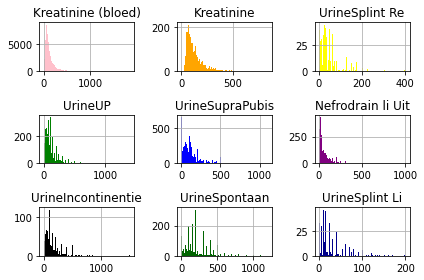

In [24]:
#Plot before distributions


#statespace overview
# 6840,   --Natrium
#         6642,   --ABP Mean Blood Pressure
#         6679,   --Niet invasieve bloeddruk gemiddeld
#         6835,   --Kalium mmol/l 
#         6836,   --Kreatinine µmol/l (erroneously documented as µmol)
#         8794,   --UrineCAD
#         8796,   --UrineSupraPubis
#         8798,   --UrineSpontaan
#         8800,   --UrineIncontinentie
#         8803,   --UrineUP
#         8843,   --ABP gemiddeld II
#         9924,   --Natrium (bloed)
#         9927,   --Kalium (bloed) mmol/l
#         9941,   --Kreatinine (bloed) µmol/l
#         9555,   --Natrium Astrup
#         9556,   --Kalium Astrup mmol/l
#         10284,  --Na (onv.ISE) (bloed)
#         10285,  --K (onv.ISE) (bloed) mmol/l
#         10743,  --Nefrodrain li Uit
#         10745,  --Nefrodrain re Uit
#         14216,  --KREAT enzym. (bloed) µmol/l
#         19921,  --UrineSplint Li
#         19922   --UrineSplint Re

#actionspace overview
# 6818, -- Adrenaline (Epinefrine)
#         7178, -- Dobutamine (Dobutrex)
#         7179, -- Dopamine (Inotropin)
#         7229, -- Noradrenaline (Norepinefrine)
#         7291  -- Crystalloid (fluid)


#cols1 = ['Kalium (bloed)', 'ABP gemiddeld', 'Kreatinine (bloed)', 'Natrium (bloed)', 'UrineCAD', 'UrineSupraPubis', '']
cols1 = list(statespace['item'].unique())

#cols2 =  ['UrineSpontaan', 'UrineUP', 'Kreatinine', 'Nefrodrain re Uit', 'Nefrodrain li Uit', 'UrineIncontinentie']
colors = ["pink", "orange", "yellow", "green", "blue", "purple", "black", "darkgreen", "darkblue", "grey", "lightblue", "red"]

def plot_dist(colnames):
  fig=plt.figure()
  for i, var_name in enumerate(colnames):
      ax=fig.add_subplot(3,3,i+1)
      statespace['value'][statespace['item'] == var_name].hist(bins=100,ax=ax, color=colors[i])
      ax.set_title(var_name)
  fig.tight_layout()  # Improves appearance a bit.
  plt.show()

plot_dist(cols1[0:9])

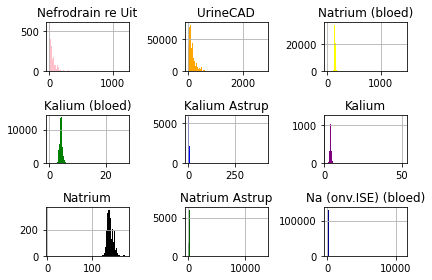

In [26]:
plot_dist(cols1[9:18])

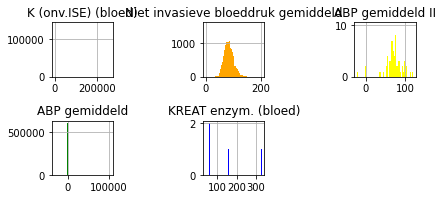

In [27]:
plot_dist(cols1[18::])

In [28]:
statespace['item'].value_counts()

ABP gemiddeld                         610367
UrineCAD                              454991
K (onv.ISE) (bloed)                   136781
Na (onv.ISE) (bloed)                  131793
Natrium (bloed)                        56709
Kalium (bloed)                         54928
Kreatinine (bloed)                     48460
Niet invasieve bloeddruk gemiddeld     24016
Kalium Astrup                           7864
Natrium Astrup                          7747
UrineSupraPubis                         5292
Kalium                                  3040
Natrium                                 3028
UrineUP                                 2897
Kreatinine                              2568
Nefrodrain re Uit                       2333
Nefrodrain li Uit                       2311
UrineSpontaan                           2182
UrineIncontinentie                       905
UrineSplint Re                           537
UrineSplint Li                           423
ABP gemiddeld II                         129
KREAT enzy

In [30]:
test = to_cols(statespace)

In [42]:
pd.set_option('display.max_rows', None)
test = test[(test['ABP gemiddeld'].isnull() == False) & (test['ABP gemiddeld II'].isnull() == False)]

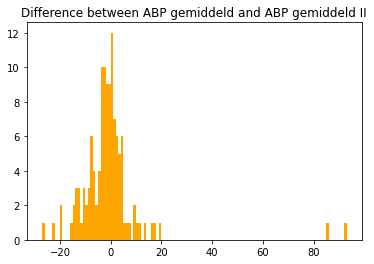

In [54]:
test_flat = test.reset_index()
plt.hist(test_flat['ABP gemiddeld'] - test_flat['ABP gemiddeld II'], color='orange', bins=120);
plt.title('Difference between ABP gemiddeld and ABP gemiddeld II');

In [ ]:
#patient id=0 before preprocessing
pd.set_option('display.max_rows', 100)
data['time'] = pd.to_datetime(data['measuredat'], unit='ms')
data[data['admissionid'] == 0].sort_values(by = "measuredat")

In [ ]:
statespace = process_statespace(data)

In [ ]:
#check for one patient whether the aggregations are correct
statespace[statespace['admissionid'] == 0]

In [ ]:
from numpy.lib import histograms
variables = ['Kalium (bloed)', 'ABP gemiddeld', 'Kreatinine (bloed)', 'Natrium (bloed)', 'UrineCAD', 'UrineSupraPubis']

draw_histograms(statespace, variables, 3, 3)

In [ ]:
variables2 = ['UrineSpontaan', 'UrineUP', 'Kreatinine', 'Nefrodrain re Uit', 'Nefrodrain li Uit', 'UrineIncontinentie']
draw_histograms(statespace, variables2, 3, 3)

In [ ]:
statespace

**Action** **Space**

In [ ]:
action = pd.read_csv('action_space.csv')
action['time'] = pd.to_datetime(action['stop'] - action['start'], unit='ms')
action = action.drop(columns = ['start', 'stop'])

In [ ]:
action['administered'][action['item'] == 'Noradrenaline (Norepinefrine)'].mean()

In [ ]:
action['administered'][action['item'] == 'NaCl 0,45%/Glucose 2,5%'].max()

In [ ]:
#check for 1 patient
pd.set_option('display.max_rows', 135)
action[action['admissionid'] == 4251]

In [ ]:
actionspace = process_actionspace(action)

In [ ]:
actionspace['Noradrenaline (Norepinefrine)'].max()

In [ ]:
actionspace[actionspace['admissionid'] == 4251]

**Combine two dataframes** 

In [ ]:
#take first 48 hours per patient
statespace = statespace.sort_values(by=['admissionid', 'time'])
statespace48h = statespace.groupby('admissionid').head(12)

In [ ]:
action.isnull().sum()

In [ ]:
#we need to know the gender, otherwise we cannot compute AKI --> nans are dropped
genders = action[['admissionid', 'gender']].dropna()

In [ ]:
#add gender to dataframe
def check_gender(admissionid):
  try:
    gender = genders['gender'][genders['admissionid'] == admissionid].head(1).item()
  except ValueError:
    gender = "Unknown"
  return gender

In [ ]:
#add gender to dataframe
def check_age(admissionid):
  age = action['agegroup'][action['admissionid'] == admissionid].head(1).item()
  return age

In [ ]:
statespace48h['gender'] = [check_gender(x) for x in statespace48h['admissionid']]

In [ ]:
#remove unknowns, as we need to know the gender to compute the AKI
statespace48h = statespace48h[statespace48h.gender != 'Unknown']

In [ ]:
statespace48h['agegroup'] = [check_age(x) for x in statespace48h['admissionid']]

In [ ]:
statespace48h['agegroup'].value_counts()

In [ ]:
#Agegroup is categorical --> encode them into a numerical variable
# agegroups = pd.get_dummies(statespace48h['agegroup'])
# statespace48h = pd.concat([statespace48h, agegroups], axis=1)

ages = {"agegroup": {"18-39": 1, "40-49": 2, "50-59": 3, "60-69":4, "70-79":5, "80+":6}}
statespace48h = statespace48h.replace(ages)
statespace48h

In [ ]:
#df with 1 row per patient for demographic stats
demo = statespace48h.drop_duplicates(subset=['admissionid'], keep='first')

In [ ]:
#add AKI feature

def AKI(kreatinine, gender):
  if gender == 'Vrouw':
    if kreatinine > 106 and kreatinine <= 134:
      return 1
    if kreatinine > 134 and kreatinine <= 205:
      return 2
    if kreatinine > 205:
      return 3
    else:
      return 0
  if gender == 'Man':
    if kreatinine > 119 and kreatinine <= 151:
      return 1
    if kreatinine > 151 and kreatinine <= 231:
      return 2
    if kreatinine > 231:
      return 3
    else:
      return 0

In [ ]:
#add AKI to every row in statespace
statespace48h['AKI'] = statespace48h.apply(lambda row: AKI(row['Kreatinine (bloed)'], row['gender']), axis=1)

In [ ]:
statespace48h['AKI'].value_counts()

In [ ]:
#merge datasets --> left merge on actionspace, as states without actions are not useful for our model
space = actionspace.merge(statespace48h, on=["admissionid", "time"], how="left")

In [ ]:
#all the null values are patients that are not in the state space and only in the action space --> we cannot use them so they are dropped
space.isnull().sum()
space = space.dropna()

In [ ]:
#one hot encode gender
space = pd.get_dummies(space, columns = ['gender'])


In [ ]:
#save final space in the drive
#space.to_csv("space_correct_demo7.csv")

In [ ]:
space[space['admissionid'] == 4251]